# 加载数据

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [7]:
# 设置随机种子
SEED=222
np.random.seed(SEED)

In [8]:
df=pd.read_csv('files/data/Python88/input.csv')

In [10]:
def get_train_test(test_size=0.95):

    y = 1 * (df.cand_pty_affiliation == "REP")

    X = df.drop(["cand_pty_affiliation"], axis=1)

    X = pd.get_dummies(X, sparse=True)

    X.drop(X.columns[X.std() == 0], axis=1, inplace=True)
    X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=test_size, random_state=SEED)
    return train_test_split(X, y, test_size=test_size, random_state=SEED)

X_train, X_test, y_train, y_test = get_train_test()
print("\nExample data:")

df.head()



Example data:


,cand_pty_affiliation,cand_office_st,cand_office,cand_status,rpt_tp,transaction_tp,entity_tp,state,classification,cycle,transaction_amt
0,REP,US,P,C,Q3,15,IND,NY,Engineer,2016.0,500.0
1,DEM,US,P,C,M5,15E,IND,OR,Math-Stat,2016.0,50.0
2,DEM,US,P,C,M3,15,IND,TX,Scientist,2008.0,250.0
3,DEM,US,P,C,Q2,15E,IND,IN,Math-Stat,2016.0,250.0
4,REP,US,P,C,12G,15,IND,MA,Engineer,2016.0,184.0


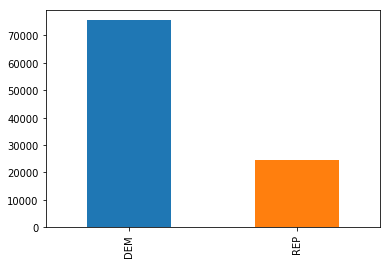

In [11]:
%matplotlib inline
df['cand_pty_affiliation'].value_counts().plot(kind='bar')

从上图可以看出，75% 的捐款是给民主党的

我们使用 ROC-AUC 来评估模型性能。如果你之前没用过该指标，随机猜测可以是 0.5 分，完美的召回率和精确率是 1.0。

## 模型集成

想象一下你在玩常识问答游戏。一个人玩时，可能会有一些题你完全不了解。如果我们想获得高分，就需要组建一个团队来覆盖所有相关主题。这就是集成的基本概念：结合多个模型的预测，对特异性误差取平均，从而获得更好的整体预测结果。

一个重要问题是如何结合预测。以常识问答游戏为例，我们很容易想象到团队成员可能会使用多数投票的方式确定选择哪个答案。机器学习的分类问题也是一样：作出最常见的类别标签预测相当于多数投票规则。但是也有很多其他方式可以结合预测，通常我们会使用一个模型来学习如何最好地结合预测结果。

![](https://www.dataquest.io/blog/content/images/2018/01/ensemble_network.png)基础集成的结构。输入输送至一系列模型中，元学习器将多个模型的预测结果结合起来。

https://www.jiqizhixin.com/articles/2018-01-14-8

## 决策树

我们用一个简单的可解释性模型来解释集成：使用 if-then 规则的决策树。决策树越深，可以捕捉的模式就越复杂，不过也更有可能出现过拟合。因此，我们需要另一种方式来构建决策树的复杂模型，而不同决策树的集成就是这样一种方式。

In [12]:
import pydotplus
from IPython.display import Image
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier,export_graphviz
def print_graph(clf, feature_names):

    """Print decision tree."""

    graph = export_graphviz(

        clf,

        label="root",

        proportion=True,

        impurity=False, 

        out_file=None, 

        feature_names=feature_names,

        class_names={0: "D", 1: "R"},

        filled=True,

        rounded=True

    )

    graph = pydotplus.graph_from_dot_data(graph)  

    return Image(graph.create_png())

在训练数据上用决策树拟合一个节点（决策规则），查看它在测试集上的性能：

Decision tree ROC-AUC score: 0.672


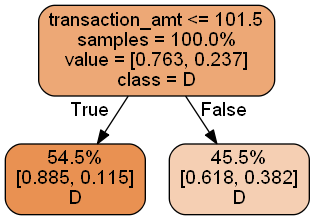

In [13]:
t1 = DecisionTreeClassifier(max_depth=1, random_state=SEED)

t1.fit(X_train, y_train)

p = t1.predict_proba(X_test)[:, 1]


print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(y_test, p))

print_graph(t1, X_train.columns)

每个叶节点记录它们在训练样本中的比例、类别分布和类别标签预测。我们的决策树根据捐款金额是否超过 101.5 进行预测：它竟然作出了同样的预测！鉴于 75% 的捐款都给了民主党，这个结果并不令人惊讶。但是这没有充分利用我们已有的数据，下面我们使用三层决策规则，看看会得到什么

Decision tree ROC-AUC score: 0.751


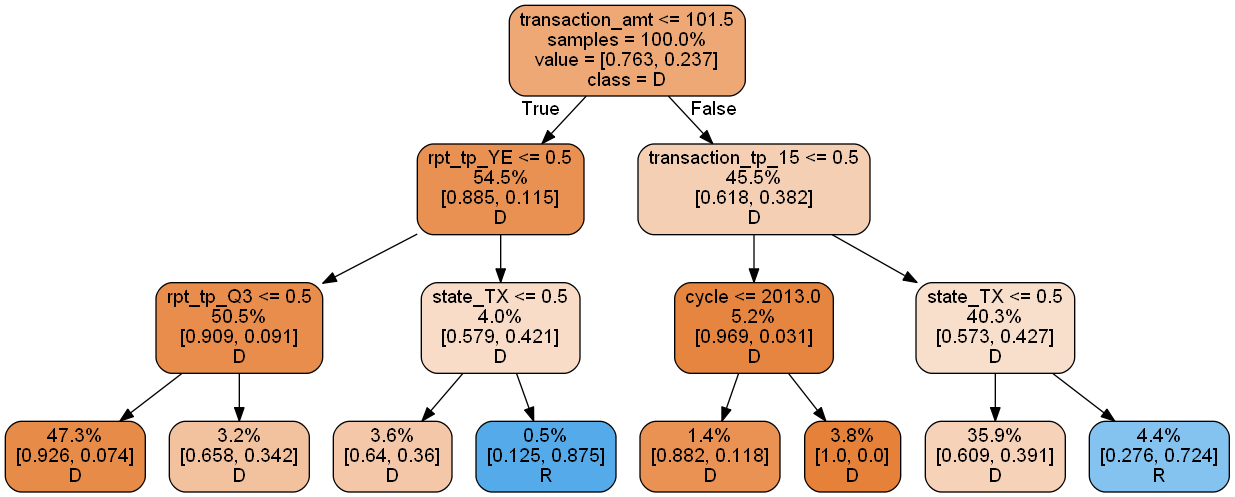

In [14]:
t2 = DecisionTreeClassifier(max_depth=3, random_state=SEED)

t2.fit(X_train, y_train)

p = t2.predict_proba(X_test)[:, 1]


print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(y_test, p))

print_graph(t2, X_train.columns)

该模型并不比简单的决策树好太多：预测到的共和党捐款金额比例只有 5%，远远低于 25%。仔细观察会发现该决策树使用了很多不确定的分割规则（splitting rule）。观察结果中高达 47.3% 的结果在最左边的叶节点中，而 35.9% 在右二的叶节点中。因此大量叶节点没有关联。使该模型更深只会导致过拟合。

在深度固定的情况下，决策树可以通过增加「宽度」的方式来增加复杂度，即创建多个决策树，并将其连接起来。也就是决策树的集成。想了解这个集成模型为什么会起作用，先要考虑我们如何让决策树探索出比上层树更多的其他模式。


最简单的解决方案就是删除树中较早出现的特征。假如我们删除了转账金额特征（transaction_amt），树的根节点，则新的决策树如下：

Decision tree ROC-AUC score: 0.740


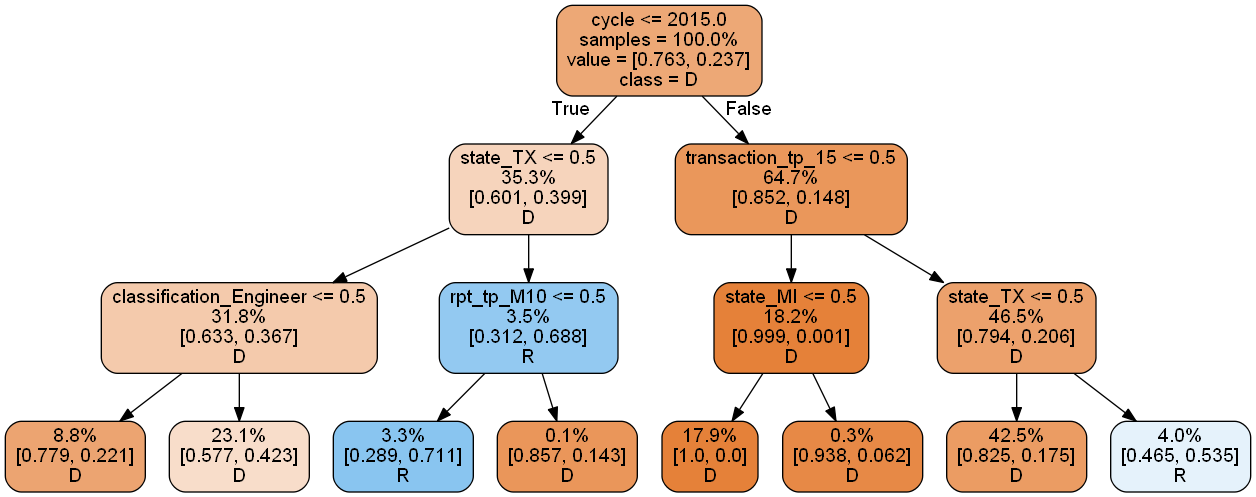

In [15]:
drop = ["transaction_amt"]

xtrain_slim = X_train.drop(drop, 1)

xtest_slim = X_test.drop(drop, 1)


t3 = DecisionTreeClassifier(max_depth=3, random_state=SEED)

t3.fit(xtrain_slim, y_train)

p = t3.predict_proba(xtest_slim)[:, 1]



print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(y_test, p))

print_graph(t3, xtrain_slim.columns)

ROC-AUC 得分与上树得分类似，但是共和党捐款比例增加至 7.3%。还是很低，但比之前稍高一些。重要的是，与第一个树相反（第一个树大部分规则与转账本身相关），这棵树更专注于候选人的居住地。现在我们有两个模型，二者预测能力相近，但基于不同的规则运行。因此，它们可能出现不同的预测误差，我们可以使用集成方法取其平均数。

##  为什么平均预测有作用

假如我们要基于两个观察结果生成预测。第一个观察结果的真正标签为共和党，第二个是民主党。在该示例中，假设模型 1 预测结果是民主党，模型 2 预测结果是共和党，如下表所示：
![](https://image.jiqizhixin.com/uploads/wangeditor/c897487a-bf02-4023-9355-24c747d7ef62/544483.png)

如果我们使用标准的 50% 分割规则（50% cutoff rule）进行类别预测，每个决策树的预测结果都是一个正确一个错误。我们对模型的类别概率取平均来创建一个集成。在该示例中，模型 2 对观察结果 1 的预测是确定的，而模型 1 相对来说不那么确定。集成对二者的预测进行衡量，然后支持模型 2，正确地预测了共和党。至于第二个观察结果，局面扭转过来，集成正确地预测到民主党：
![](https://image.jiqizhixin.com/uploads/wangeditor/c897487a-bf02-4023-9355-24c747d7ef62/71742%E5%B1%8F%E5%B9%95%E5%BF%AB%E7%85%A7%202018-01-13%20%E4%B8%8A%E5%8D%8811.18.09.png)

如果集成包含两个以上决策树，则它根据多数原则进行预测。因此，集成对分类器预测结果取平均又叫作多数投票分类器（majority voting classifier）。当集成基于概率取平均时，我们称其为软投票，而对类别标签预测结果取平均被成为硬投票。

当然，集成不是万能的。你可能注意到上述示例中，取平均有效的前提是预测误差必须不相关。如果两个模型都作出了错误的预测，则集成无法作出进行修正。此外，在软投票机制中，如果一个模型作出了错误的预测，但概率值较高，则集成可能会作出错误的判断。通常，集成无法使每个预测都正确，但是预计其性能优于底层模型。

## 森林是树的集成

回到我们的预测问题，看看我们是否可以用两个决策树构建一个集成。首先检查误差关联性：高度关联的误差会造成差的集成。

In [17]:
p1 = t2.predict_proba(X_test)[:, 1]
p2 = t3.predict_proba(xtest_slim)[:, 1]

pd.DataFrame({"full_data": p1,
              "red_data": p2}).corr()

,full_data,red_data
full_data,1.000000,0.669128
red_data,0.669128,1.000000


有一些关联性，但不过分：预测方差仍有很大的利用空间。为了构建该集成，我们简单地平均了两个模型的预测。

In [20]:
p1 = t2.predict_proba(X_test)[:, 1]

p2 = t3.predict_proba(xtest_slim)[:, 1]

p = np.mean([p1, p2], axis=0)

print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(y_test, p))

Average of decision tree ROC-AUC score: 0.783


确实，集成步骤导致分值增加。但是如果我们有更多不同的树，我们甚至可以得到更大的分值。在设计决策树时，我们应该去除哪些特征？

一个快速有效的实践方法是随机地选择一个特征子集，在每个 draw 上拟合一个决策树并平均其预测。这一过程被称为自举平均（bootstrapped averaging，通常缩写为 bagging），它应用于决策树所产生的模型是随机森林。让我们看看随机森林能为我们做什么。我们使用 Scikit-learn 实现构建了 10 个决策树的集成，每一个拟合包含 3 个特征的子集。

In [21]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(

    n_estimators=10,

    max_features=3,

    random_state=SEED

)


rf.fit(X_train, y_train)

p = rf.predict_proba(X_test)[:, 1]

print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(y_test, p))

E:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Average of decision tree ROC-AUC score: 0.844


随机森林极大改进了我们之前的模型。但是只使用决策树可以做的事情比较有限。是时候扩展我们的视野了。

## 作为平均预测的集成

目前为止，我们看到了集成的两个重要方面：

1. 预测误差的关联性越低，效果越好
|
2. 模型越多，效果越好

出于这一原因，尽可能使用不同模型不失为一个好方法（只要它们表现良好）。目前为止我们一直在依赖简单的平均，但是稍后我们将了解如何使用更复杂的结合。为了记录进程，我们把集成公式化为如下：
![](https://image.jiqizhixin.com/uploads/wangeditor/c897487a-bf02-4023-9355-24c747d7ef62/326496.png)

涵盖的模型没有限制：决策树、线性模型、核模型、非参数模型、神经网络，或者甚至其他集成！记住我们包含的模型越多，集成的速度就会越慢。

为了构建不同模型的集成，我们首先在数据集上对一组 Scikit-learn 分类器进行基准测试。为了避免代码重复，我们使用下面的辅助函数：

In [24]:
from sklearn.svm import SVC, LinearSVC

from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier

from sklearn.neural_network import MLPClassifier

from sklearn.kernel_approximation import Nystroem

from sklearn.kernel_approximation import RBFSampler

from sklearn.pipeline import make_pipeline



def get_models():

    """Generate a library of base learners."""

    nb = GaussianNB()

    svc = SVC(C=100, probability=True)

    knn = KNeighborsClassifier(n_neighbors=3)

    lr = LogisticRegression(C=100, random_state=SEED)

    nn = MLPClassifier((80, 10), early_stopping=False, random_state=SEED)

    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)

    rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=SEED)


    models = {'svm': svc,

              'knn': knn,

              'naive bayes': nb,

              'mlp-nn': nn,

              'random forest': rf,

              'gbm': gb,

              'logistic': lr,

              }


    return models



def train_predict(model_list):

    """Fit models in list on training set and return preds"""

    P = np.zeros((y_test.shape[0], len(model_list)))

    P = pd.DataFrame(P)


    print("Fitting models.")

    cols = list()

    for i, (name, m) in enumerate(models.items()):

        print("%s..." % name, end=" ", flush=False)

        m.fit(X_train, y_train)

        P.iloc[:, i] = m.predict_proba(X_test)[:, 1]

        cols.append(name)

        print("done")


    P.columns = cols

    print("Done.\n")

    return P



def score_models(P, y):

    """Score model in prediction DF"""

    print("Scoring models.")

    for m in P.columns:

        score = roc_auc_score(y, P.loc[:, m])

        print("%-26s: %.3f" % (m, score))

    print("Done.\n")
    
models = get_models()

P = train_predict(models)

score_models(P, y_test)

Fitting models.
svm... done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done
Done.

Scoring models.
svm                       : 0.850
knn                       : 0.779
naive bayes               : 0.803
mlp-nn                    : 0.851
random forest             : 0.844
gbm                       : 0.878
logistic                  : 0.857
Done.



这是我们的基线。梯度提升机（Gradient Boosting Machine/GBM）效果最好，其次是简单的 logistic 回归。对于我们的集成策略来说，预测误差必须是相对不关联的。

[MLENS] backend: threading


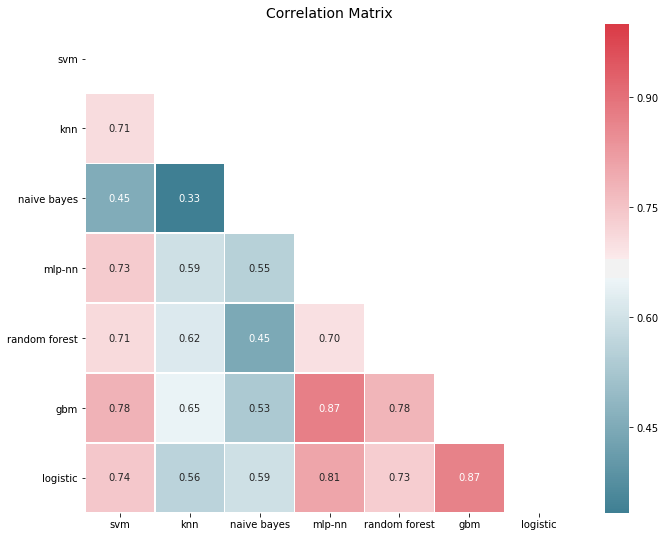

In [25]:
from mlens.visualization import corrmat


corrmat(P.corr(), inflate=False)

plt.show()

误差明显关联，这对于表现良好的模型是可以预期的，因为它是典型的异常值，很难纠正。然而，大多数关联性在 50-80％的范围内，所以还有很大的改进余地。事实上，如果我们从类别预测的角度看误差关联性，事情看起来会更有希望：

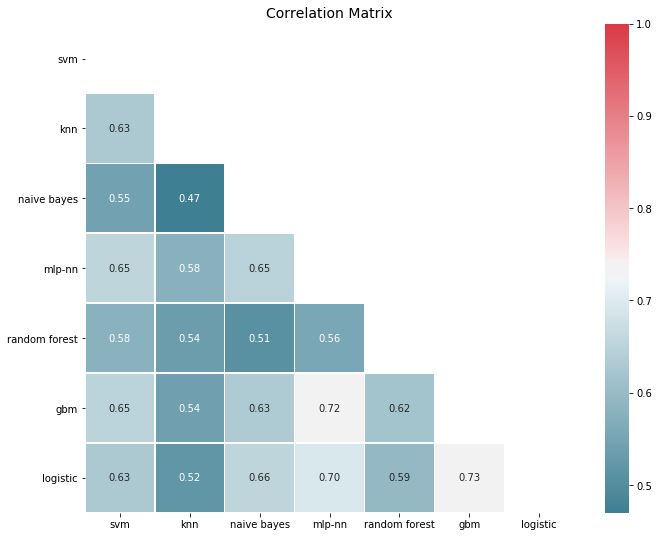

In [27]:
corrmat(P.apply(lambda pred: 1*(pred >= 0.5) - y_test.values).corr(), inflate=False)

plt.show()

为了创建集成，我们继续并进行平均预测，正如我们所期望的，集成的性能要好于基线。平均化是一个简单的过程，如果我们存储模型预测，我们可以从一个简单的集成开始，并在训练新模型时随时增加其大小。

In [28]:
print("Ensemble ROC-AUC score: %.3f" % roc_auc_score(y_test, P.mean(axis=1)))

Ensemble ROC-AUC score: 0.884


## 可视化集成的工作过程

我们已经对集成的误差关联机制有所了解。这意味着集成通过平均谬误可以平滑决策边界。决策边界向我们表明评估器如何将特征空间分割成邻域，其中所有的观察结果被预测为具有相同的分类标签。通过平均基学习器决策边界，集成被赋予更平滑的边界，泛化也更自然。

下图展示了这一点。这里的实例是鸢尾花数据集，其中评估者试图对三种花进行分类。基学习器在其边界都有一些不良的特性，但是这个集成有一个相对平滑的决策边界，与观察结果一致。令人惊讶的是，集成既增加了模型的复杂度，也起到了正则化项的作用！
![三个模型及其集成的决策边界示例](https://www.dataquest.io/blog/content/images/2018/01/ensemble_decision_regions_2d.jpg)


当任务是分类时，另一种理解集成的方式是检查 ROC 曲线（Receiver Operator Curve），它向我们展示了评估者如何进行精确率和召回率之间的权衡。通常，不同的基学习器做出不同的权衡：一些通过牺牲召回率实现更高的精确率，另一些则相反。

另一方面，对于每个训练点，非线性元学习器可以调整其依赖的模型。这意味其可以极大地减少不必要的牺牲，并在增加召回率的同时保持高精确率（反之亦然）。下图中，集成在精确率上做了一个更小的牺牲，以增加召回率。

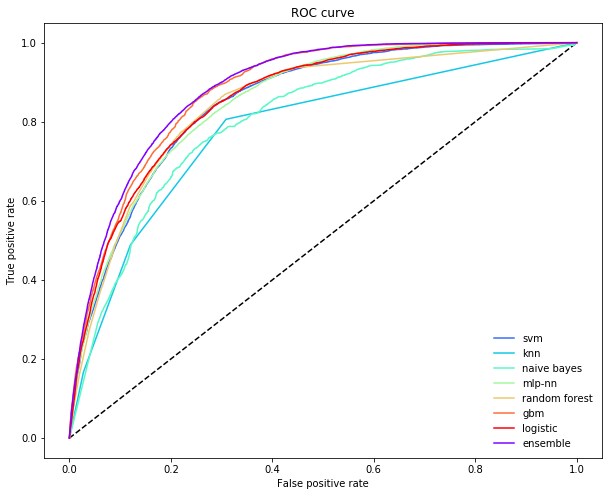

In [30]:
from sklearn.metrics import roc_curve


def plot_roc_curve(ytest, P_base_learners, P_ensemble, labels, ens_label):

    """Plot the roc curve for base learners and ensemble."""

    plt.figure(figsize=(10, 8))

    plt.plot([0, 1], [0, 1], 'k--')


    cm = [plt.cm.rainbow(i)

      for i in np.linspace(0, 1.0, P_base_learners.shape[1] + 1)]


    for i in range(P_base_learners.shape[1]):

        p = P_base_learners[:, i]

        fpr, tpr, _ = roc_curve(y_test, p)

        plt.plot(fpr, tpr, label=labels[i], c=cm[i + 1])


    fpr, tpr, _ = roc_curve(y_test, P_ensemble)

    plt.plot(fpr, tpr, label=ens_label, c=cm[0])


    plt.xlabel('False positive rate')

    plt.ylabel('True positive rate')

    plt.title('ROC curve')

    plt.legend(frameon=False)

    plt.show()



plot_roc_curve(y_test, P.values, P.mean(axis=1), list(P.columns), "ensemble")

## 超越简单平均值的集成
但是在预测误差变动一定的情况下，你不会期望更多的提升吗？一些模型表现要比其他模型相对糟糕，但是其影响一样大。这对不平衡数据集来说是毁灭性的：如果一个模型做出极端预测（即接近于 0 或 1），则通过软投票召回，因为其对预测平均值有极大的影响。

对我们来说，一个重要的因素是模型是否可以捕捉到共和党所收捐款的全部比例。一个简单的检查表明所有模型对共和党捐款比例的预测都过低，其中一些相对更糟。

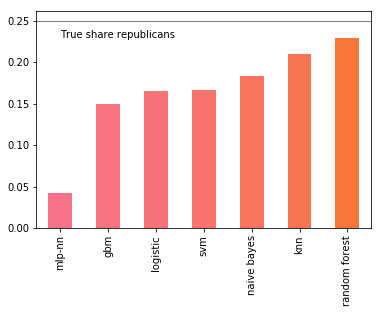

In [32]:
p = P.apply(lambda x: 1*(x >= 0.5).value_counts(normalize=True))

p.index = ["DEM", "REP"]

p.loc["REP", :].sort_values().plot(kind="bar")

plt.axhline(0.25, color="k", linewidth=0.5)

plt.text(0., 0.23, "True share republicans")

plt.show()

我们尝试通过去除最糟糕的来提升集成，比如说多层感知机（MLP）：

In [33]:
include = [c for c in P.columns if c not in ["mlp-nn"]]

print("Truncated ensemble ROC-AUC score: %.3f" % roc_auc_score(y_test, P.loc[:, include].mean(axis=1)))

Truncated ensemble ROC-AUC score: 0.883


实际上不算提升：我们需要一个更聪明的方式来排定模型之间的优先顺序。很明显，从一个集成中删除模型是相当猛烈的，因为有可能删除带有重要信息的模型。我们真正想要的是学习平均预测时使用的一组合理的权重。这把集成变成了一个需要训练的参数化模型。

## 学习结合预测
学习加权平均值意味着对于每个模型 f_i 都有一个权重参数 ω_i∈(0,1) 将权重分配给该模型的预测。加权平均值需要所有的权重总和为 1。现在，集成的定义如下：
![](https://image.jiqizhixin.com/uploads/wangeditor/c897487a-bf02-4023-9355-24c747d7ef62/21256640-8.png)
这与之前的定义有一些小的改变，但是很有趣的一点是：一旦模型生成预测 p_i=f_i(x)，则学习权重就相当于基于预测来拟合线性回归：
![](https://image.jiqizhixin.com/uploads/wangeditor/c897487a-bf02-4023-9355-24c747d7ef62/38083640-9.png)
权重有一些约束项。然后，我们不用仅拟合线性模型了。假设我们拟合最近邻模型。集成会基于给定观察结果的最近邻取局部平均值，这样集成就可以适应模型性能随着输入变化而产生的改变。

## 实现集成

要构建这种类型的集成，我们需要：

1. 用于生成预测的基学习器库；

2. 学习如何最佳结合预测结果的元学习器；

3. 在基学习器和元学习器之间分割训练数据的方法。

基学习器采用原始输入，生成一系列预测。如果我们的原始数据集是形态为 (n_samples, n_features) 的矩阵 X，那么基学习器库输出新的预测矩阵 P_base，形态为 (n_samples, n_base_learners)，其中每一列代表一个基学习器的预测结果。元学习器在 P_base 上训练。

这意味着恰当地处理训练集 X 至关重要。尤其是，如果我们在 X 上训练基学习器，用它们预测 X，则元学习器将在基学习器的训练误差上训练，但在测试时元学习器将面对基学习器的测试误差。

我们需要一种策略来生成反映测试误差的预测矩阵 P。最简单的策略是将完整的数据集 X 分割成两部分：在其中一半上训练基学习器，然后让它们预测另一半，然后将预测输入元学习器。这种方法又简单又快，不过会丢失一些数据。对于中小型规模的数据集，信息丢失可能会比较严重，导致基学习器和元学习器性能不好。

为了保证覆盖完整的数据集，我们可以使用交叉验证法。有很多方式可以执行交叉验证，在那之前，我们先来一步一步地实现集成。

第一步：定义基学习器的库

它们是处理输入数据并生成预测的模型，可以是线性回归，也可以是神经网络，甚至可以是另一个集成。和往常一样，多样性是强大的！唯一需要注意的是，我们加入越多的模型，集成运行的速度就会越慢。在这里，我会使用此前的模型集合：

In [35]:
base_learners = get_models()

第二步：定义一个元学习器

应该使用哪个元学习器，人们并没有统一看法，但目前流行的选择是线性模型、基于核的模型（支持向量机和 KNN 算法）以及基于决策树的模型。你也可以使用另一个集成作为「元学习器」：在这种特殊情况下，你最终会得到一个两层的集成，这有点类似于前馈神经网络。

在这里，我们会使用一个梯度提升机。为了确保 GBM 能够探索局部特征，我们需要限定每 1000 个决策树在 4 个基学习器的随机子集和 50% 的输入数据上进行训练。这样，GBM 就会表达每个基学习器在不同近邻输入空间上的预测内容。

In [36]:
meta_learner = GradientBoostingClassifier(

    n_estimators=1000,

    loss="exponential",

    max_features=4,

    max_depth=3,

    subsample=0.5,

    learning_rate=0.005, 

    random_state=SEED

)

第三步：定义步骤，生成训练和测试集

为简单起见，我们将完整训练集分为基学习器的训练集和预测集。这种方法有时被称为「混合（Blending）」。不过，不同社区之间的术语是不同的，所以知道集成使用了哪种类型的交叉验证有时并不容易。

In [38]:
xtrain_base, xpred_base, ytrain_base, ypred_base = train_test_split(

    X_train, y_train, test_size=0.5, random_state=SEED)

我们现在有一个为基学习器准备的训练集（X_train_base,y_train_base）和一个预测集（X_pred_base,y_pred_base），准备好为元学习器生成预测矩阵了。

第四步：在训练集上训练基学习器

为在训练数据上训练基学习器，我们照常运行：

In [39]:
def train_base_learners(base_learners, inp, out, verbose=True):

    """Train all base learners in the library."""

    if verbose: print("Fitting models.")

    for i, (name, m) in enumerate(base_learners.items()):

        if verbose: print("%s..." % name, end=" ", flush=False)

        m.fit(inp, out)

        if verbose: print("done")

为训练基学习器，我们需要执行：

In [40]:
train_base_learners(base_learners, xtrain_base, ytrain_base)

Fitting models.
svm... done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done


第五步：生成基学习器预测

基学习器拟合后，我们现在可以生成一系列预测用于训练元学习器。注意，我们生成的基于观测值的预测并不会用于基学习器的训练，对于每个观测：
![](https://image.jiqizhixin.com/uploads/wangeditor/c897487a-bf02-4023-9355-24c747d7ef62/14476640-10.png)
在基学习器预测集中，我们生成了基学习器预测结果的集合：
![](https://image.jiqizhixin.com/uploads/wangeditor/c897487a-bf02-4023-9355-24c747d7ef62/25369640-11.png)
如果你实现自己的集成，请特别注意如何索引预测矩阵的行和列——将数据分成两个部分并不难，但对于后来的交叉验证就很有挑战性了。


In [41]:
def predict_base_learners(pred_base_learners, inp, verbose=True):

    """Generate a prediction matrix."""

    P = np.zeros((inp.shape[0], len(pred_base_learners)))


    if verbose: print("Generating base learner predictions.")

    for i, (name, m) in enumerate(pred_base_learners.items()):

        if verbose: print("%s..." % name, end=" ", flush=False)

        p = m.predict_proba(inp)

        # With two classes, need only predictions for one class

        P[:, i] = p[:, 1]

        if verbose: print("done")


    return P

为生成预测，我们需要执行

In [43]:
P_base = predict_base_learners(base_learners, xpred_base)

Generating base learner predictions.
svm... done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done


第六步：训练元学习器

预测矩阵 P_base 反映了测试时间的性能，可被用于训练元学习器：

In [44]:
meta_learner.fit(P_base, ypred_base)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005, loss='exponential', max_depth=3,
              max_features=4, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=222, subsample=0.5, verbose=0,
              warm_start=False)

就是这样！我们现在有了完全训练的集成，可用来预测新数据了。为生成观测值 x(j) 的预测，我们先要将其输入基学习器。它们输出一系列预测
![](https://image.jiqizhixin.com/uploads/wangeditor/c897487a-bf02-4023-9355-24c747d7ef62/58837640-12.png)
我们再将其输入元学习器。元学习器会给我们集成的最终预测
![](https://image.jiqizhixin.com/uploads/wangeditor/c897487a-bf02-4023-9355-24c747d7ef62/71578640-13.png)
现在我们对于集成学习有了一个明确的认识，是时候看看它能对政治捐款数据集做出怎样的预测了：

In [45]:
def ensemble_predict(base_learners, meta_learner, inp, verbose=True):

    """Generate predictions from the ensemble."""

    P_pred = predict_base_learners(base_learners, inp, verbose=verbose)

    return P_pred, meta_learner.predict_proba(P_pred)[:, 1]

为生成预测，我们需要执行：

In [48]:
P_pred, p = ensemble_predict(base_learners, meta_learner, X_test)

print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(y_test, p))

Generating base learner predictions.
svm... done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done

Ensemble ROC-AUC score: 0.881


正如我们所料，集成击败了此前基准的最佳估计，但它仍然无法击败简单的平均集成。这是因为我们只对一半的数据进行基学习器和元学习器的训练，所以大量的信息丢失了。为了防止这点，我们需要使用交叉验证策略。

## 利用交叉验证训练

在交叉验证训练基学习器时，每个基学习器的备份都进行了 K-1 fold 的拟合，并进行了剩余 fold 的预测。这一过程不断重复，直到每个 fold 都被预测。我们指定的 fold 越多，每次训练过程中的数据就越少。这使得交叉验证的预测在测试期间噪声更小，性能更好。但这显著增加了训练时间。通过交叉验证拟合一个集成经常被称为堆叠（stacking），而集成本身会被称为超级学习器（Super Learner）。

为理解交叉验证是如何运作的，我们可以把它想象为之前集成的一个外循环（outer loop）。外循环在个格不同的测试 fold 上迭代，而其余的数据用于训练；内循环训练基学习器并产生预测数据。这是一个简单的堆叠实现：

In [49]:
from sklearn.base import clone


def stacking(base_learners, meta_learner, X, y, generator):

    """Simple training routine for stacking."""


    # Train final base learners for test time

    print("Fitting final base learners...", end="")

    train_base_learners(base_learners, X, y, verbose=False)

    print("done")


    # Generate predictions for training meta learners

    # Outer loop:

    print("Generating cross-validated predictions...")

    cv_preds, cv_y = [], []

    for i, (train_idx, test_idx) in enumerate(generator.split(X)):


        fold_xtrain, fold_ytrain = X[train_idx, :], y[train_idx]

        fold_xtest, fold_ytest = X[test_idx, :], y[test_idx]


        # Inner loop: step 4 and 5

        fold_base_learners = {name: clone(model)

                              for name, model in base_learners.items()}

        train_base_learners(

            fold_base_learners, fold_xtrain, fold_ytrain, verbose=False)


        fold_P_base = predict_base_learners(

            fold_base_learners, fold_xtest, verbose=False)


        cv_preds.append(fold_P_base)

        cv_y.append(fold_ytest)

        print("Fold %i done" % (i + 1))


    print("CV-predictions done")


    # Be careful to get rows in the right order

    cv_preds = np.vstack(cv_preds)

    cv_y = np.hstack(cv_y)


    # Train meta learner

    print("Fitting meta learner...", end="")

    meta_learner.fit(cv_preds, cv_y)

    print("done")


    return base_learners, meta_learner

让我们来看看这里涉及的步骤。首先，我们在所有数据上拟合基学习器：这与之前的混合集成相反，基学习器在测试时间内训练了所有数据。随后我们遍历所有 fold，随后遍历所有基学习器生成交叉验证预测。这些预测堆叠在一起构成了元学习器的训练集——它也训练了所有数据。

混合和堆叠的基本区别在于，堆叠允许基学习器和元学习器在全部数据集上进行训练。使用双重交叉验证，我们可以测量这种情况下的差异：

In [54]:
from sklearn.model_selection import KFold


# Train with stacking

cv_base_learners, cv_meta_learner = stacking(

    get_models(), clone(meta_learner), X_train.values, y_train.values, KFold(2))


P_pred, p = ensemble_predict(cv_base_learners, cv_meta_learner, X_test, verbose=False)

print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(y_test, p))

Fitting final base learners...done
Generating cross-validated predictions...
Fold 1 done
Fold 2 done
CV-predictions done
Fitting meta learner...done

Ensemble ROC-AUC score: 0.889


集成 的 ROC-AUC 分数：0.889

堆叠带来了可观的性能提升：事实上，它得到了目前的最佳分数。对于中小型数据集来说，这种成绩是非常典型的，其中混合的影响比重很大。随着数据集体量的增大，混合与堆叠的表现会逐渐趋同。

堆叠也有自己的缺点，特别是速度。通常，在交叉验证的情况下，我们需要知道这些问题：

1. 计算复杂度

2. 结构复杂度（信息泄露的风险）

3. 内存用量

理解它们对于高效使用集成方法来说非常重要，让我们一一道来。

1. 计算复杂度

假设我们需要使用 10 折堆叠。这需要在 90% 的数据上训练所有基学习器 10 次，然后在所有数据上再训练一次。若有 4 个基学习器，集成需要花费的时间大约是最佳基学习器的 40 倍。

但每个 cv-fit 都是独立的，所以我们不需要依次拟合模型。如果我们能够平行拟合所有 fold，集成就只会比最佳基学习器慢 4 倍——这是一个巨大的提升。集成是并行化的最佳受益者，能够充分利用这一机制对它来说至关重要。为所有模型拟合所有 fold，集成的时间惩罚就可以忽略不计了。为了介绍这一点，下图是 ML-Ensemble 上的一个基准，它展示了 4 个线程上依次或并行堆叠或混合拟合所花费的时间。
![](https://www.dataquest.io/blog/content/images/2018/01/scale_cpu-1.png)
即使有了这种程度的并行性，我们也可以减少大量计算时间。然而，并行化与一系列潜在的棘手问题有关，如竞态条件、锁死和内存爆炸。

2. 结构复杂度

当我们决定在元学习器上使用整个训练集时，我们必须关注「信息泄露」问题。当错误地预测训练期间使用的样本时，就会出现这种现象，例如混合了不同的 fold，或使用了错误的训练子集。当元学习器在训练集上出现信息泄露时，预测错误就会产生：garbage in、garbage out。发现这样的 bug 是非常困难的。

3. 内存用量

并行化的最后一个问题，特别是在 Python 中多任务处理时经常会碰到的问题。在这种情况下，每个子进程都有自己的内存，同时需要复制父进程中所有的数据。因此，一个未做优化的实现会复制程序的所有数据，占用大量内存，浪费数据序列化的时间。为阻止这种情况，我们需要共享数据存储器，而这反过来又容易导致数据损坏。

结果：使用工具包

这一问题的结果是需要使用一个经过测试、且为你的机器学习方法构建的软件包。事实上，一旦你用上了集成工具包，构建集成就会变得非常简单：你需要做的仅仅是选定基学习器、元学习器，以及训练集成的方法。

幸运的是，今天每个流行的编程语言里都有很多可用的工具包——虽然它们有着不同的风格。在本文的末尾我会列举其中的一些。现在，让我们选用其中的一个，看看集成方法是如何处理政治捐款数据集的。在这里，我们使用 ML-Ensemble 来构建我们之前提到的广义集合，但现在使用 10 折交叉验证。

In [51]:
from mlens.ensemble import SuperLearner


# Instantiate the ensemble with 10 folds

sl = SuperLearner(

    folds=10,

    random_state=SEED,

    verbose=2,

    backend="multiprocessing"

)


# Add the base learners and the meta learner

sl.add(list(base_learners.values()), proba=True) 

sl.add_meta(meta_learner, proba=True)


# Train the ensemble

sl.fit(X_train, y_train)


# Predict the test set

p_sl = sl.predict_proba(X_test)


print("\nSuper Learner ROC-AUC score: %.3f" % roc_auc_score(y_test, p_sl[:, 1]))


Fitting 2 layers
Processing layer-1             done | 00:01:27
Processing layer-2             done | 00:00:02
Fit complete                        | 00:01:30

Predicting 2 layers
Processing layer-1             done | 00:00:43
Processing layer-2             done | 00:00:01
Predict complete                    | 00:00:45

Super Learner ROC-AUC score: 0.890


就是这么简单！

观察超级学习器简单平均集合的 ROC 曲线，其中展示了超级学习器如何利用全部数据仅牺牲少量召回率即可获得给定精确率。

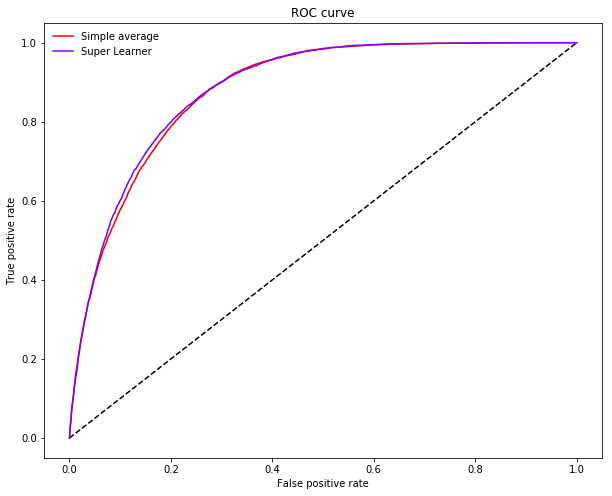

In [52]:
plot_roc_curve(y_test, p.reshape(-1, 1), P.mean(axis=1), ["Simple average"], "Super Learner")

继续进发

除了本文介绍的几种集成外，目前还有很多其他的集成方式，不过它们的基础都是一样的：一个基学习器库、一个元学习器，以及一个训练程序。通过调整这些组件的配合，我们可以设计出各种特定的集合形式。有关更高级集合的内容请参阅这篇文章：https://mlwave.com/kaggle-ensembling-guide/。

当我们谈到软件时，每个人都有自己的喜好。随着集成方法的流行，集成工具包的数量也越来越多。实际上集成方法是先在统计学社区中流行起来的，所以 R 语言中有很多为此设计的库。近年来，Python 和其他语言中也出现了更多相关工具。每个工具包都能满足不同的需求，处于不同的成熟阶段，所以我建议大家选用前先浏览一番再做决策。 